In [1]:
import sys

sys.path.append("..")

import pickle as pkl

import cv2
import numpy as np
import pandas as pd
import plotly.express as px
from cbdetect_py import (
    CornerType,
    Params,
    boards_from_corners,
    find_corners,
    hessian_response,
)
from ipywidgets import FloatSlider, IntRangeSlider, interact
from pandas.compat import os
from PIL import Image, ImageOps
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

from calibration.benchmark.benchmark import (
    BenchmarkResult,
    benchmark_babelcalib,
    benchmark_simul,
)
from calibration.data.babelcalib.babelcalib import load_babelcalib
from calibration.data.babelcalib.entry import Entry
from calibration.feature_detector.checkerboard import (
    detect_corners,
    get_corner_candidates,
    non_maximum_suppression,
    normalize_image,
    refine_corners,
)
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.feature_refiner.classifier import get_corner_responses

# from calibration.feature_refiner.classifier import

%load_ext autoreload
%autoreload 2

In [2]:
with open("../babelcalib_results_None.pkl", "rb") as f:
    results = pkl.load(f)

In [3]:
path = "responsesses.npy"
if os.path.isfile(path):
    responsesses = np.load(path)
else:
    responsesses = process_map(
        get_corner_responses,
        results,
        chunksize=10,
        max_workers=8,
    )
    np.save(path, responsesses)

# Single image

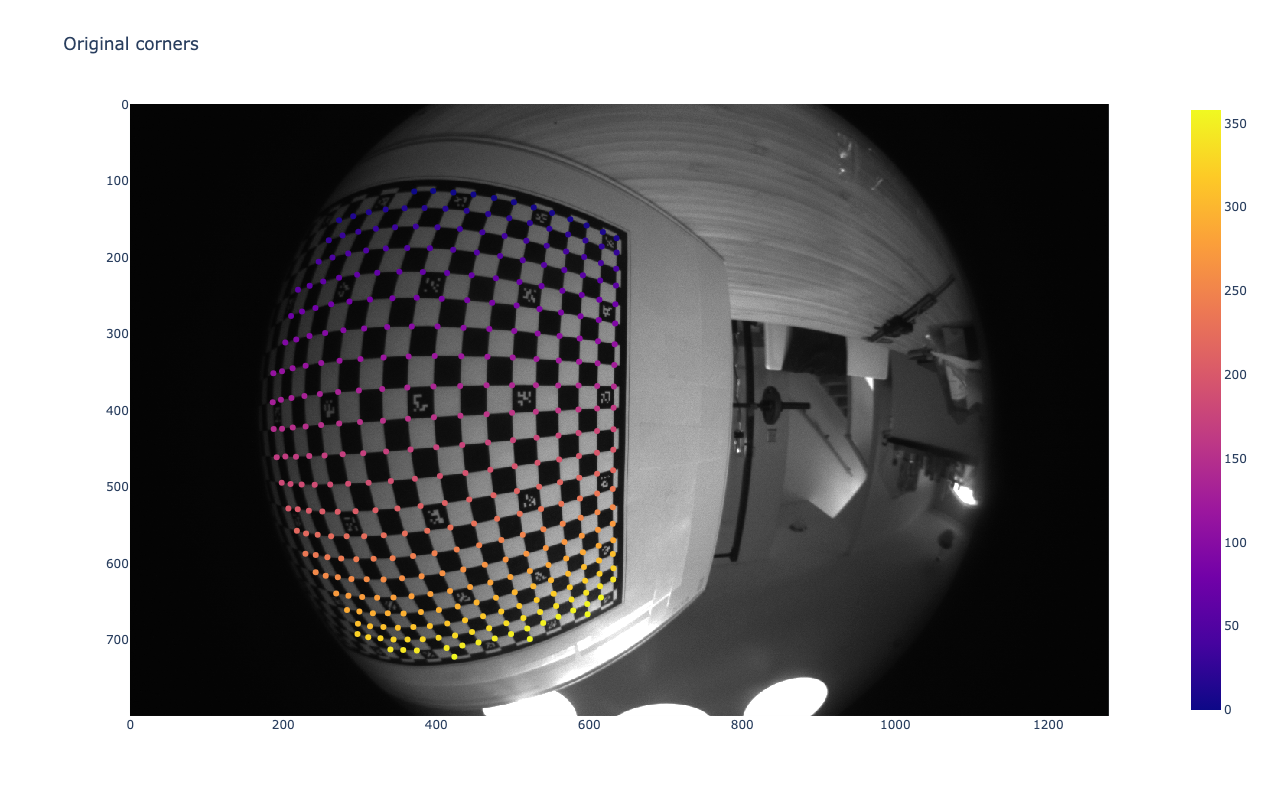

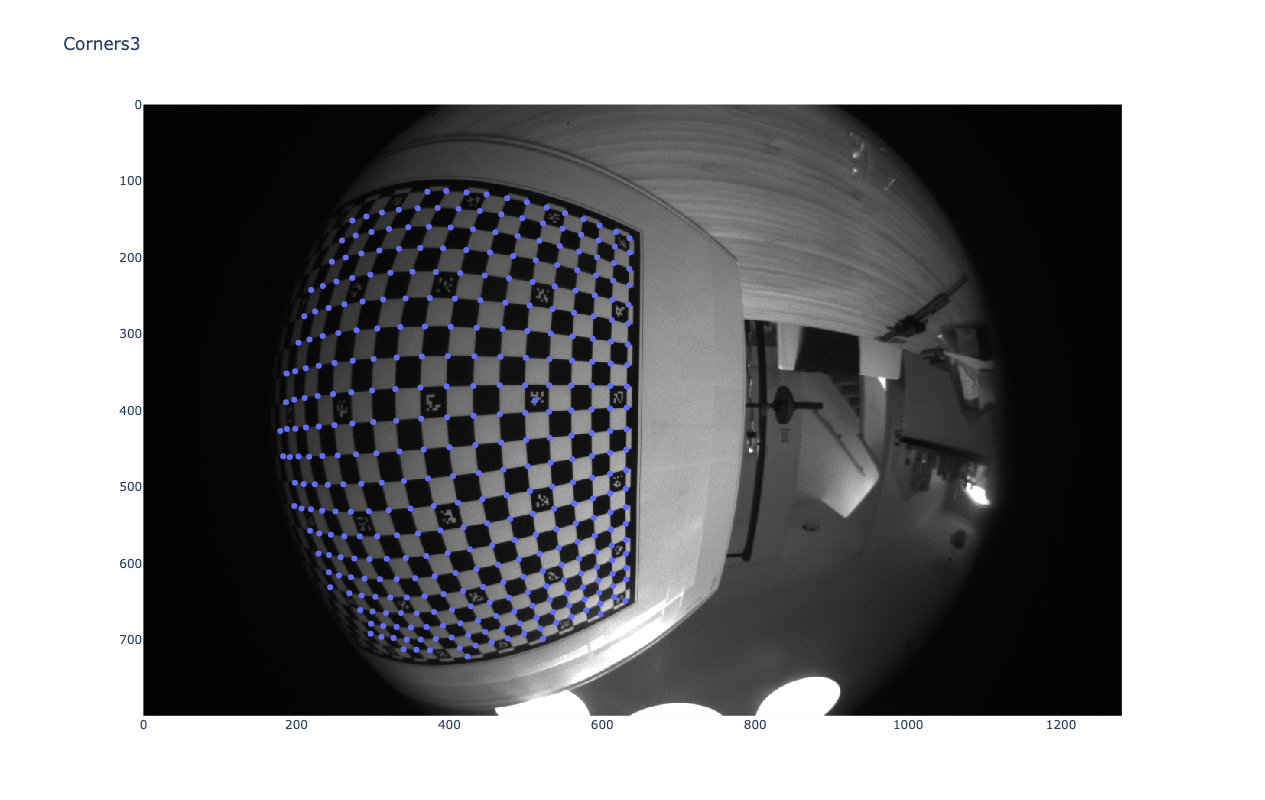

In [4]:
r = results[600]
w, h = r.input.image.size

display(
    show_boards(
        np.array(r.input.image), r.features.corners, r.features.board
    ).update_layout(height=h, width=w, title="Original corners")
)
from cbdetect_py import CornerType, Params, boards_from_corners, find_corners

gray = np.array(r.input.image)

params = Params()
params.corner_type = CornerType.SaddlePoint
params.show_processing = False
# params.show_debug_image = True

img = gray

corners = find_corners(img, params)
show_corners(gray, np.array(corners.p)).update_layout(
    height=h, width=w, title="Corners3"
)

In [ ]:
r.input.image.save("Image_for_responses.png")

In [ ]:
px.imshow(hessian_response(np.array(r.input.image)))

In [ ]:
px.imshow(hessian_response(np.array(r.input.image)).repeat(2, axis=0).repeat(2, axis=1))

In [ ]:
gray = np.array(r.input.image)
diff = normalize_image(gray)
winsize = 9
radiuses = [3, 5]
if winsize >= 8:
    radiuses.append(winsize - 3)

corr = detect_corners(diff, radiuses=radiuses)

display(px.imshow(corr).update_layout(height=h, width=w, title="Corr"))
corrb = cv2.GaussianBlur(corr, (7, 7), 3)
corners = get_corner_candidates(corrb, winsize + 2, np.max(corrb) * 0.2)
display(
    show_corners(gray, corners[:, (1, 0)]).update_layout(
        height=h, width=w, title="Corners1"
    )
)
corners = non_maximum_suppression(corners, winsize - 2)
display(
    show_corners(gray, corners[:, (1, 0)]).update_layout(
        height=h, width=w, title="Corners2"
    )
)
corners_sp = refine_corners(corners, diff, winsize=winsize + 2)
display(
    show_corners(gray, corners[:, (1, 0)]).update_layout(
        height=h, width=w, title="Corners3"
    )
)

In [ ]:
responces = get_corner_responses(r)

df_ = pd.DataFrame(np.vstack(responces), columns=["Response", "Distance"])

df_["Distance < 1.5"] = df_["Distance"] < 1.5

px.histogram(
    df_,
    x="Response",
    color="Distance < 1.5",
    log_y=True,
    barmode="overlay",
    nbins=1000,
    title='Histogram of "cornerness" responses (note the logarithmic y axis)',
)

In [ ]:
px.violin(
    df_.assign(Rounded_distance=df_["Distance"].astype(int)),
    y="Response",
    x="Rounded_distance",
    title='Violin plot of "cornerness" responses with respect to distance',
)

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=2, random_state=42).fit(
    responces[:, 0][:, np.newaxis]
)
gm.means_

# All images

In [ ]:
responsesses = np.vstack(responsesses)
np.save(path, responsesses)
responsesses.shape

In [ ]:
df_ = pd.DataFrame(responsesses, columns=["Response", "Distance"])

df_["Distance < 1.5"] = df_["Distance"] < 1.5

px.histogram(
    df_,
    x="Response",
    color="Distance < 1.5",
    log_y=True,
    barmode="overlay",
    nbins=1000,
    # title='Histogram of "cornerness" responses (note the logarithmic y axis)',
).write_image('cornerness_histogram.png')

In [ ]:
df_ = pd.DataFrame(responsesses, columns=["Response", "Distance"])

df_["Distance < 0.5"] = df_["Distance"] < 0.5

px.histogram(
    df_,
    x="Response",
    color="Distance < 0.5",
    barmode="overlay",
    log_y=True,
    nbins=1000,
    height=800,width=1500,
    # title='Histogram of "cornerness" responses (note the linear y axis)',
).write_image("hist_hessian.png")

In [ ]:
px.violin(
    df_.assign(Rounded_distance=df_["Distance"].astype(int)),
    y="Response",
    x="Rounded_distance",
    title='Violin plot of "cornerness" responses with respect to distance',
).show("svg")

# ROC AUC curve

Label true only the corners

In [ ]:
px.histogram(x=responsesses[:, 1]).show("svg")

In [ ]:
# respensesses = np.vstack(responsesses)
from sklearn.metrics import auc, roc_curve

scores = responsesses[:, 0]
true_labels = responsesses[:, 1] <= 0.1

fpr, tpr, thr = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr)

df = pd.DataFrame({"False Positive Rate": fpr, "True Positive Rate": tpr})

fig = px.line(
    df,
    x="False Positive Rate",
    y="True Positive Rate",
    title=f"ROC Curve (AUC = {roc_auc:.2f})",
)

fig.add_scatter(x=[0, 1], y=[0, 1], mode="lines", line=dict(dash="dash"), name="Random")

fig.update_layout(
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    autosize=False,
    width=500,
    height=500,
)

fig.write_image("ROC_AUC_hessian.svg")

In [ ]:
px.line(y=thr)

In [ ]:
# Calculate the G-mean for each threshold
gmeans = np.sqrt(tpr * (1 - fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)

print("Best Threshold=%f" % thr[ix])

Label true corners and +- 1 px

In [ ]:
scores = responsesses[:, 0]
true_labels = responsesses[:, 1] <= 1.5

fpr, tpr, thr = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr)

df = pd.DataFrame({"False Positive Rate": fpr, "True Positive Rate": tpr})

fig = px.line(
    df,
    x="False Positive Rate",
    y="True Positive Rate",
    title=f"ROC Curve (AUC = {roc_auc:.2f})",
)

fig.add_scatter(x=[0, 1], y=[0, 1], mode="lines", line=dict(dash="dash"), name="Random")

fig.update_layout(
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    autosize=False,
    width=500,
    height=500,
)

fig.write_image("ROC_AUC_hessian.svg")

In [ ]:
px.line(y=thr)

In [ ]:
# Calculate the G-mean for each threshold
gmeans = np.sqrt(tpr * (1 - fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)

print("Best Threshold=%f" % thr[ix])